In [1]:
import pandas as pd 
import numpy as np 

In [2]:
import pandas as pd
df  = pd.read_csv("D:\personal Projects\classical ML\gr.noida rent prediction (web scrapping)\greater_noida_rents_massive.csv")
df.head()

,BHK,Price,Location,Area,Furnishing,Tenant_Pref,Full_Title,Page_Found
0,2 BHK,"₹17,000 /month",Mahagun Mywoods Phase 1,850 sqft(79 sqm),NaN,Not Specified,"2 BHK Flat for rent in Sector 16C, Greater Noida",1
1,3 BHK,"₹35,000 /month",ACE Divino,"1,565 sqft(145 sqm)",NaN,Not Specified,3 BHK Flat for rent in Noida Extension,1
2,2 BHK,"₹25,000 /month",Ace City,"1,080 sqft(100 sqm)",NaN,Not Specified,2 BHK Flat for rent in Sector 1 Greater Noida ...,1
3,2 BHK,"₹25,000 /month",C block,"1,615 sqft(150 sqm)",Furnished,Not Specified,2 BHK Independent Builder Floor for rent in Si...,1
4,NaN,"₹55,000 /month",Panchsheel Villas,"1,080 sqft(100 sqm)",Furnished,Not Specified,"5 Bedroom House for rent in Sector 16B, Greate...",1


In [3]:
print('Shape of Data:',df.shape)
print('----'*20,'\n Data Types Info:')
print(df.info())

Shape of Data: (2526, 8)
-------------------------------------------------------------------------------- 
 Data Types Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   BHK          2293 non-null   object
 1   Price        2526 non-null   object
 2   Location     2526 non-null   object
 3   Area         2526 non-null   object
 4   Furnishing   735 non-null    object
 5   Tenant_Pref  2526 non-null   object
 6   Full_Title   2526 non-null   object
 7   Page_Found   2526 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 158.0+ KB
None


# Data Cleaning

In [4]:
print(df.isnull().sum())
print('----'*20,'\n Tenent_pref Value Counts:')
print(df['Tenant_Pref'].value_counts())

BHK             233
Price             0
Location          0
Area              0
Furnishing     1791
Tenant_Pref       0
Full_Title        0
Page_Found        0
dtype: int64
-------------------------------------------------------------------------------- 
 Tenent_pref Value Counts:
Tenant_Pref
Not Specified        2471
Family Preferred       39
Bachelors Allowed      10
Family Only             5
Boys Only               1
Name: count, dtype: int64


In [5]:
import re
import pandas as pd

# list of noisy property words that should NOT be treated as a sector/address
property_words = [
    "flat", "flats", "bhk", "bedroom", "bedrooms", "house", "independent",
    "builder floor", "floor", "studio", "apartment", "room", "rooms",
    "for rent", "rent", "sale", "residential", "resale"
]
prop_regex = r"\b(?:" + "|".join(re.escape(w) for w in property_words) + r")\b"

# 1) Primary targeted extraction for known block names / sectors (require number/letter or known word)
pattern_primary = (
    r"(Sector\s*[A-Za-z0-9]+|"
    r"Alpha\s*\w*|Beta\s*\w*|Gamma\s*\w*|Delta\s*\w*|Chi\s*\w*|"
    r"Phi\s*\w*|Omega\s*\w*|Zeta\s*\w*)"
)

df['Sector'] = df['Full_Title'].str.extract(pattern_primary, expand=False)

# 2) Fallback: text after "in " up to comma, parenthesis, or hyphen (most likely contains the address)
fallback = df['Full_Title'].str.extract(r"in\s+([^,()\-\n]+)", expand=False)

# 3) Fill primary NaNs with fallback
df['Sector'] = df['Sector'].fillna(fallback)

# 4) Remove property-type noise from the extracted value
df['Sector'] = (
    df['Sector']
      .astype(str)                                      # safe cast
      .str.replace(prop_regex, "", regex=True, flags=re.IGNORECASE)  # remove property words
      .str.replace(r"\b(Greater Noida|Noida|Noida Extension|Greater Noida West)\b", "", regex=True, case=False)
      .str.replace(r"[,:\-\(\)]", "", regex=True)     # remove punctuation
      .str.strip()
      .replace({"": pd.NA, "nan": pd.NA})             # empty -> NaN
)

# 5) Validation: keep only if it looks like a block/sector/address.
#    We require either:
#      - the word "Sector" OR
#      - a known block name (Alpha/Beta/Chi/...) OR
#      - at least one digit in the result (e.g. "16C", "4", "Block 12")
valid_pattern = re.compile(r"(?i)^(?:.*Sector.*|.*Alpha.*|.*Beta.*|.*Gamma.*|.*Chi.*|.*Delta.*|.*Omega.*|.*Zeta.*|.*\d.*)$")

mask_valid = df['Sector'].notna() & df['Sector'].str.match(valid_pattern)
df.loc[~mask_valid, 'Sector'] = pd.NA

# 6) Optional: tidy casing and normalize "sector" words
df['Sector'] = df['Sector'].str.replace(r"^sector\s+", "Sector ", flags=re.IGNORECASE, regex=True)
df['Sector'] = df['Sector'].str.title()

# Quick checks
print("Remaining NaNs in Sector:", df['Sector'].isnull().sum())
print("Sample extracted values (non-null):")
print(df['Sector'].dropna().unique()[:50])


Remaining NaNs in Sector: 341
Sample extracted values (non-null):
['Sector 16C' 'Sector 1' 'Sigma 4' 'Sector 16B' 'Sector 10'
 'Techzone 4  West' 'Sector 27' 'Sector Zeta' 'Sector 16' 'Sector Chi'
 'Sector 4' 'Sector' 'Sector Pi' 'Sector 2' 'Sector Xu' 'Sector P4'
 'Sector 31' 'Sector Omicron' 'Techzone 4' 'Eta 2' 'Nh 91' 'Sector Mu'
 'Delta 1' 'Sector 3' 'Alpha 2' 'Sector Phi' 'Sector 22D' 'Gamma 2'
 'Beta 1' 'Ecotech 3' 'Knowledge Park 3' 'Delta I' 'Sector P3' 'Sigma 2'
 'Site 5' 'Beta 2' 'Rho 1 Sector' 'Sector 25' 'Ecotech 1 Extension'
 'Chi Phi' 'Sigma 1' 'Delta 3' 'Sector Omega' 'Alpha 1' 'Gamma 1']


In [6]:
df.isnull().sum()

BHK             233
Price             0
Location          0
Area              0
Furnishing     1791
Tenant_Pref       0
Full_Title        0
Page_Found        0
Sector          341
dtype: int64

In [7]:
df.dropna(subset=['Sector'], inplace=True)
df.dropna(subset=['BHK'], inplace=True)
df.isnull().sum()

BHK               0
Price             0
Location          0
Area              0
Furnishing     1529
Tenant_Pref       0
Full_Title        0
Page_Found        0
Sector            0
dtype: int64

In [8]:
df.head()


,BHK,Price,Location,Area,Furnishing,Tenant_Pref,Full_Title,Page_Found,Sector
0,2 BHK,"₹17,000 /month",Mahagun Mywoods Phase 1,850 sqft(79 sqm),NaN,Not Specified,"2 BHK Flat for rent in Sector 16C, Greater Noida",1,Sector 16C
2,2 BHK,"₹25,000 /month",Ace City,"1,080 sqft(100 sqm)",NaN,Not Specified,2 BHK Flat for rent in Sector 1 Greater Noida ...,1,Sector 1
3,2 BHK,"₹25,000 /month",C block,"1,615 sqft(150 sqm)",Furnished,Not Specified,2 BHK Independent Builder Floor for rent in Si...,1,Sigma 4
5,3 BHK,"₹21,000 /month",Arihant Abode,"1,160 sqft(108 sqm)",NaN,Not Specified,3 BHK Flat for rent in Sector 10 Greater Noida...,1,Sector 10
6,4 BHK,"₹26,000 /month",La Residentia,"1,538 sqft(143 sqm)",Semi-Furnished,Not Specified,4 BHK Flat for rent in Techzone 4 Greater Noid...,1,Techzone 4 West


In [9]:
cols_to_drop = [
    'Location',
    'Furnishing',
    'Tenant_Pref',
    'Full_Title',
    'Page_Found'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.head()

,BHK,Price,Area,Sector
0,2 BHK,"₹17,000 /month",850 sqft(79 sqm),Sector 16C
2,2 BHK,"₹25,000 /month","1,080 sqft(100 sqm)",Sector 1
3,2 BHK,"₹25,000 /month","1,615 sqft(150 sqm)",Sigma 4
5,3 BHK,"₹21,000 /month","1,160 sqft(108 sqm)",Sector 10
6,4 BHK,"₹26,000 /month","1,538 sqft(143 sqm)",Techzone 4 West


In [10]:
# Changing BHK col into int
df['BHK'] = df['BHK'].str.extract(r'(\d+)').astype(int)

#changing Price Col into Int
df['Price (Rupee)'] = (
    df['Price']
    .str.replace('₹', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.extract(r'(\d+)')[0]
    .astype(int)
)
# changing Area col into int
# FIX for Cell 10
# Remove commas first, then extract
df['Area_sqft'] = df['Area'].str.replace(',', '').str.extract(r'(\d+)\s*sqft')[0].astype(int)

#dropping original cols
cols_to_drop2 = [
    'Price',
    'Area'   
]
# dropping original cols
df = df.drop(columns=cols_to_drop2, errors='ignore')
df.head()


,BHK,Sector,Price (Rupee),Area_sqft
0,2,Sector 16C,17000,850
2,2,Sector 1,25000,1080
3,2,Sigma 4,25000,1615
5,3,Sector 10,21000,1160
6,4,Techzone 4 West,26000,1538


In [11]:
print(df.info())
print('---'*20,)
print('\n count of catagory in Sector Column is' , len(df['Sector'].unique()))

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 2525
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   BHK            2007 non-null   int32 
 1   Sector         2007 non-null   object
 2   Price (Rupee)  2007 non-null   int32 
 3   Area_sqft      2007 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 54.9+ KB
None
------------------------------------------------------------

 count of catagory in Sector Column is 32


In [12]:
df['Sector'].unique()

array(['Sector 16C', 'Sector 1', 'Sigma 4', 'Sector 10',
       'Techzone 4  West', 'Sector 27', 'Sector 16', 'Sector Zeta',
       'Sector 16B', 'Sector Chi', 'Sector 4', 'Sector', 'Sector Pi',
       'Sector 2', 'Sector Xu', 'Sector P4', 'Sector 31',
       'Sector Omicron', 'Techzone 4', 'Eta 2', 'Sector Mu', 'Sector 3',
       'Alpha 2', 'Sector Phi', 'Ecotech 3', 'Gamma 2', 'Sector 22D',
       'Sigma 2', 'Beta 1', 'Beta 2', 'Rho 1 Sector', 'Sector 25'],
      dtype=object)

# Feature Engreening

Dealing with outliers

In [13]:
# Calculate global average price
global_mean = df['Price (Rupee)'].mean()

# Calculate count and mean for each sector
agg = df.groupby('Sector')['Price (Rupee)'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']

# Smoothing factor (m): higher means more reliance on the global average
m = 10 

# Formula: (count * mean + m * global_mean) / (count + m)
smooth_means = (counts * means + m * global_mean) / (counts + m)

# Map the smoothed means
df['Sector_Encoded_Smooth'] = df['Sector'].map(smooth_means)

In [14]:
df.head()

,BHK,Sector,Price (Rupee),Area_sqft,Sector_Encoded_Smooth
0,2,Sector 16C,17000,850,21969.609756
2,2,Sector 1,25000,1080,28233.073475
3,2,Sigma 4,25000,1615,25031.298788
5,3,Sector 10,21000,1160,23819.955409
6,4,Techzone 4 West,26000,1538,24797.408970


In [15]:
# Drop the original categorical column
df = df.drop(columns=['Sector'])

# Check the first few rows to ensure only numeric columns remain
print(df.head())

   BHK  Price (Rupee)  Area_sqft  Sector_Encoded_Smooth
0    2          17000        850           21969.609756
2    2          25000       1080           28233.073475
3    2          25000       1615           25031.298788
5    3          21000       1160           23819.955409
6    4          26000       1538           24797.408970


In [16]:
df['Sector_Encoded_Smooth'].isnull().sum()

0

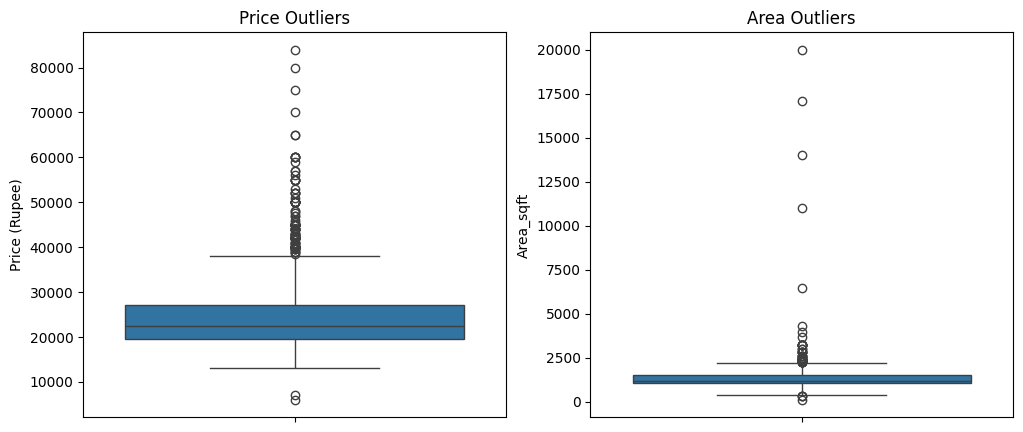

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check outliers for Price and Area side-by-side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='Price (Rupee)')
plt.title('Price Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='Area_sqft')
plt.title('Area Outliers')

plt.show()

In [18]:
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate the Interquartile Range
    IQR = Q3 - Q1
    
    # Define the bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    # Print the results for tracking
    print(f"Column: {column}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Removed {len(df) - len(df_filtered)} outliers.\n")
    
    return df_filtered

# Apply to your data
df = remove_outliers_iqr(df, 'Price (Rupee)')
df = remove_outliers_iqr(df, 'Area_sqft')

Column: Price (Rupee)
  Lower Bound: 8180.00, Upper Bound: 38292.00
  Removed 132 outliers.

Column: Area_sqft
  Lower Bound: 428.25, Upper Bound: 2086.25
  Removed 39 outliers.



Original entries: 2526
Entries after cleaning: 1836


Price (Rupee)       Axes(0.125,0.11;0.352273x0.77)
Area_sqft        Axes(0.547727,0.11;0.352273x0.77)
dtype: object

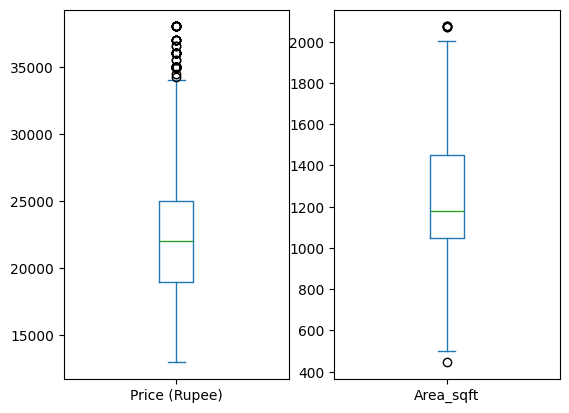

In [19]:
print(f"Original entries: 2526")
print(f"Entries after cleaning: {len(df)}")

# Check with a simple boxplot again
df[['Price (Rupee)', 'Area_sqft']].plot(kind='box', subplots=True)

In [20]:
from sklearn.preprocessing import StandardScaler

# Select features to scale (everything except the text 'Sector')
features_to_scale = ['BHK', 'Area_sqft', 'Sector_Encoded_Smooth']

scaler = StandardScaler()

# Create a copy for the scaled data
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("Data Normalized successfully!")
print(df_scaled[features_to_scale].head())

Data Normalized successfully!
        BHK  Area_sqft  Sector_Encoded_Smooth
0 -0.946805  -1.355214              -0.650690
2 -0.946805  -0.560080               1.404199
3 -0.946805   1.289473               0.353775
5  0.854578  -0.283511              -0.043637
6  2.655961   1.023276               0.277042


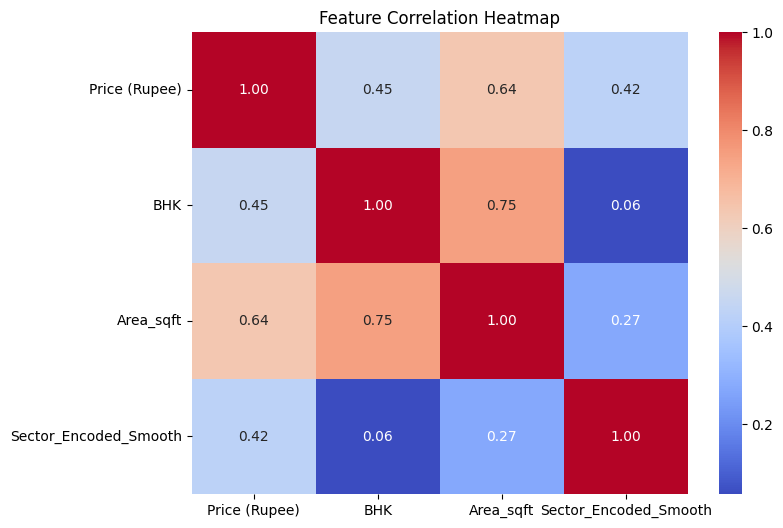

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_scaled[['Price (Rupee)', 'BHK', 'Area_sqft', 'Sector_Encoded_Smooth']].corr()

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [23]:
df_scaled.head()

,BHK,Price (Rupee),Area_sqft,Sector_Encoded_Smooth
0,-0.946805,17000,-1.355214,-0.650690
2,-0.946805,25000,-0.560080,1.404199
3,-0.946805,25000,1.289473,0.353775
5,0.854578,21000,-0.283511,-0.043637
6,2.655961,26000,1.023276,0.277042


In [ ]:
from sklearn.model_selection import train_test_split



X = df_scaled[['BHK', 'Area_sqft', 'Sector_Encoded_Smooth']]
y = df_scaled['Price (Rupee)']

# test_size=0.2 means 20% of data is kept for testing, 80% for training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Check the split results
print(f"Total rows in dataset: {len(X)}")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Total rows in dataset: 1836
Training set size: 1468
Testing set size: 368


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Linear Regression (Baseline) ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# --- Random Forest (Advanced) ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# --- Comparison Table ---
print("Linear Regression:")
print(f"  R2 Score: {r2_score(y_test, lr_preds):.3f}")
print(f"  Avg Error: ₹{mean_absolute_error(y_test, lr_preds):,.0f}")

print("\nRandom Forest Regressor:")
print(f"  R2 Score: {r2_score(y_test, rf_preds):.3f}")
print(f"  Avg Error: ₹{mean_absolute_error(y_test, rf_preds):,.0f}")

Linear Regression:
  R2 Score: 0.466
  Avg Error: ₹2,654

Random Forest Regressor:
  R2 Score: 0.484
  Avg Error: ₹2,438


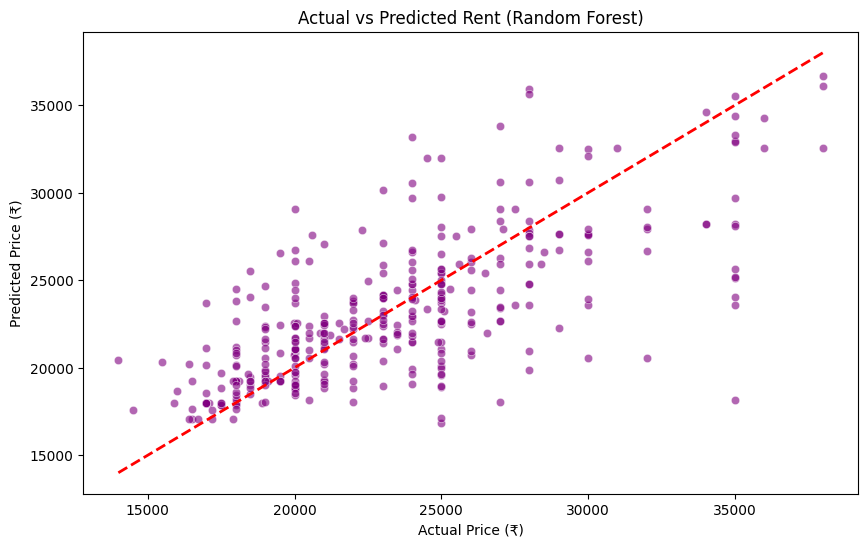

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Diagonal line
plt.title('Actual vs Predicted Rent (Random Forest)')
plt.xlabel('Actual Price (₹)')
plt.ylabel('Predicted Price (₹)')
plt.show()